*Course: Building on the SIR Model  
Institution: Imperical College London  
Presenter: Dr. Nimalan Arinaminpathy*

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Preamble

Compartmental models simplify the mathematical modelling of infectious diseases. The population is assigned to compartments with labels - for example, S, I, or R, (Susceptible, Infectious, or Recovered). People may progress between compartments. The order of the labels usually shows the flow patterns between the compartments; for example SEIS means susceptible, exposed, infectious, then susceptible again.

In [3]:
def plot_model(df, times, labels, colors):
    """
    Helper function for plotting
    Assumes df contains columns labeled S, I, R, M, V, Iv and/or T
    Returns a graph based on data in the dataframe
    """
    f, ax = plt.subplots(figsize=(10,7))
    total_pop = df.iloc[0].sum()
    
    for i, col in enumerate(df.columns):
        ax.plot(times, df[col]/total_pop, colors[i], linewidth=2, label=labels[col])
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Proportion of the Population")
    ax.legend(loc="right")
    return ax.get_figure()

### 1. Age-structured modeling

Consider the following compartments:

<img src="data/w2_nb1_model_diagram.png" />

For this model we assume there is no aging and thus no arrows between compartments 1 (children) and 2 (adults) which is not unreasonable if the infection occurs over a relatively short time period. In addition, both children and adults recover at the same rate 𝛾.

In effect, we assume age-specific mixing patterns, meaning that different ages experience different forces of infection. In the model, susceptible children experience a force of infection $\lambda_{1}$ and susceptible adults become infected at a rate $\lambda_{2}$.

The key parameters for the rate of infection are:

- 𝑏 , the probability of infection per contact
- 𝑐𝑖𝑗 , the number of contacts that a susceptible person in age group i makes with people in age group j per unit time  

Here, we are modelling an outbreak in a population (based in the UK). We assume that in Great Britain, children make 13 contacts per day on average, of which 7 are with other children, and that adults make 11 contacts per day on average, of which 10 are with other adults. This gives the following contact parameters:

- $c_{11}$ = 7  
- $c_{12}$ = 6  
- $c_{21}$ = 1  
- $c_{22}$ = 10  

We also assume that the probability of infection per contact, 𝑏, is the same for children and adults and equals 5% for the disease we are modelling, and that people remain infected on average for 5 days. The total population size is 1 million, and children make up 20% of that population.

In [4]:
b = 0.05      # the probability of infection per contact is 5%
c_11 = 7      # daily number of contacts that children make with each other
c_12 = 6      # daily number of contacts that children make with adults
c_21 = 1      # daily number of contacts that adults make with children
c_22 = 10     # daily number of contacts that adults make with each other
gamma = 1/5   # the rate of recovery is 1/5 per day

In [5]:
S1 = 200000   # 20% of the population are children - all susceptible
I1 = 1        # the outbreak starts with 1 infected person (can be either child or adult)  
R1 = 0
S2 = 800000   # 100%-20% of the population are adults - all susceptible
I2 = 0
R2 = 0

In [6]:
follow_up_duration = 90 # number of days

state = (S1, I1, R1, S2, I2, R2)
times = list(range(0, follow_up_duration+1))
parameters = (b, c_11, c_12, c_21, c_22, gamma)

In [7]:
def sir_model1(state, t, parameters):
    
    N1 = (state[0] + state[1] + state[2])
    N2 = (state[3] + state[4] + state[5])
    
    # Force of infection acting on susceptible children
    lambda_1 = (parameters[0] * parameters[1] * state[1]/N1) + (parameters[0] * parameters[2] * state[4]/N2)
    # Force of infection acting on susceptible adults:
    lambda_2 = (parameters[0] * parameters[3] * state[1]/N1) + (parameters[0] * parameters[4] * state[4]/N2)
    
    # Rate of change in children
    dS1 = -lambda_1 * state[0]              
    dI1 = lambda_1 * state[0] - gamma * state[1]
    dR1 = gamma * state[1]
    # Rate of change in adults
    dS2 = -lambda_2 * state[3]            
    dI2 = lambda_2 * state[3] - gamma * state[4]
    dR2 = gamma * state[4] 
    
    return dS1, dI1, dR1, dS2, dI2, dR2

In [8]:
def run_sir_model1(state, times, parameters):
    df = pd.DataFrame(odeint(sir_model1, state, times, (parameters,)), columns=["S1", "I1", "R1", "S2", "I2", "R2"])
    #plot_model(df, times)
    return df

df = run_sir_model1(state, times, parameters)

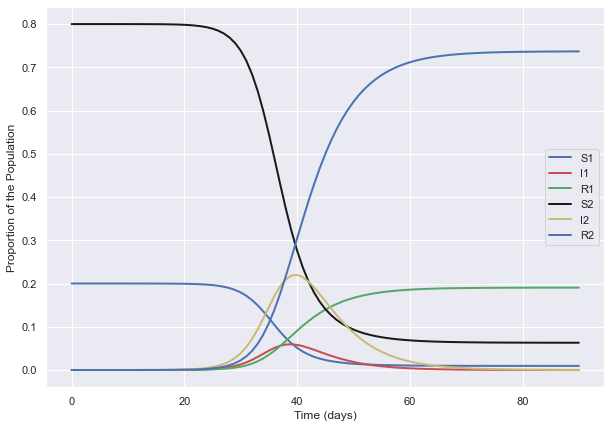

In [9]:
colors = ["b", "r", "g", "k", "y", "b"]
labels = {"S1":"S1", "I1":"I1", "R1":"R1", "S2":"S2", "I2":"I2", "R2":"R2"}

plot_model(df, times, labels, colors);

##### **Q: What was the cumulative incidence of infection during this epidemic? What proportion of those infections occurred in children?**

In [10]:
cum_incidence = (df["S1"].iloc[0] - df["S1"].iloc[-1]) + (df["S2"].iloc[0] - df["S2"].iloc[-1])
print("Total cumulative incidence:", round(cum_incidence,0))

cum_incidence_children  = (df["S1"].iloc[0] - df["S1"].iloc[-1])
cum_incidence_adults = (df["S2"].iloc[0] - df["S2"].iloc[-1])
prop_children = cum_incidence_children / (cum_incidence_children + cum_incidence_adults)
print("Proportion of infections in children:", round(prop_children, 2))

Total cumulative incidence: 927447.0
Proportion of infections in children: 0.21


##### **Q: Which age group was most affected by the epidemic?**

In [11]:
prop_children = (df["S1"].iloc[0] - df["S1"].iloc[-1]) / (S1+1)
print("Proportion of children that became infected:", round(prop_children,2))
prop_adults = (df["S2"].iloc[0] - df["S2"].iloc[-1]) / (S2+1)
print("Proportion of adults that became infected:", round(prop_adults,2))

Proportion of children that became infected: 0.95
Proportion of adults that became infected: 0.92


### 2. Extending to Multiple Age Groups  

The input information for our new model:
- The probability of infection per contact, $b$, is 5% for people of all ages
- The total population size is 1 million, and children make up 20% of this population while 15% of the population are elderly.
- The population has not been exposed to the infection before.  

The main difference is that we define the S, I and R compartments as vectors within the model function, each of length 3 for the 3 age groups. We can then define the age-specific contact pattern as a matrix. When calculating the force of infection, we multiply the contact matrix with the vector of the proportion of infected people for each age group, giving us 3 age-specific forces of infection stored in the "lambda" vector.

In [12]:
contact_matrix = np.array([[7,5,1],  # daily contacts of children with children, adults, elderly
                           [2,9,1],  # daily contacts of adults with children, adults, elderly
                           [1,3,2]]) # dailt contacts of elderly with children, adults, elderly

b = 0.05
gamma = 1/5

In [13]:
S1 = 200000  # 20% of the population are children - all susceptible
S2 = 650000  # 100%-20%-15% of the population are adults - all susceptible
S3 = 150000  # 15% of the population are elderly - all susceptible
I1 = 1       # the outbreak starts with 1 infected person (can be of either age)
I2 = 0
I3 = 0
R1 = 0
R2 = 0
R3 = 0

In [14]:
follow_up_duration = 90 # number of days

state = (S1, S2, S3, I1, I2, I3, R1, R2, R3)
times = list(range(0, follow_up_duration+1))
parameters = (b, contact_matrix, gamma)

In [15]:
def sir_age_model(state, t, parameters):
    
    n_agegroups = 3
    
    S = np.array(state[:n_agegroups])
    I = np.array(state[n_agegroups:2*n_agegroups])
    R = np.array(state[2*n_agegroups:])
    
    # people in S, I and R are added separately by age group, so N is also a vector of length 3
    N = np.sum([S,I,R], axis=0)
    
    # the lambda vector contains the forces of infection for children, adults and the elderly (length 3)
    lambda_ = b*contact_matrix @ (I/N)
    
    dS = -lambda_ * S             
    dI = lambda_ * S - gamma * I
    dR = gamma * I
    
    return np.concatenate([dS, dI, dR])

df = pd.DataFrame(odeint(sir_age_model, state, times, (parameters,)),
                  columns=["S1", "S2", "S3", "I1", "I2", "I3", "R1", "R2", "R3"])

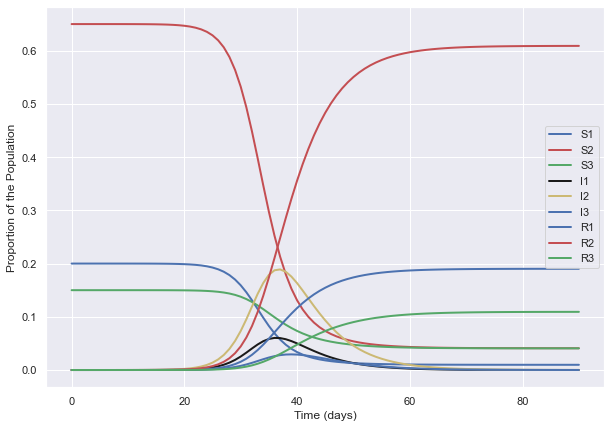

In [16]:
colors = ["b", "r", "g", "k", "y", "b", "b", "r", "g"]
labels = {"S1":"S1", "I1":"I1", "R1":"R1",
          "S2":"S2", "I2":"I2", "R2":"R2",
          "S3":"S3", "I3":"I3", "R3":"R3"}
plot_model(df, times, labels, colors);

##### **Q: How many infections occurred in each age group over the course of the epidemic, and what proportion of children, adults and elderly individuals does this represent?**

In [17]:
print("Cumulative incidence in children:", df["S1"].iloc[0] - df["S1"].iloc[-1])
print("Cumulative incidence in adults:", df["S2"].iloc[0] - df["S2"].iloc[-1])
print("Cumulative incidence in the elderly:", df["S3"].iloc[0] - df["S3"].iloc[-1])

Cumulative incidence in children: 190215.37169985325
Cumulative incidence in adults: 609095.450734737
Cumulative incidence in the elderly: 109311.07452775256


190,215 children, 609,095 adults and 109,311 elderly people were infected over the course of this outbreak. Dividing these by the age-specific population sizes of 200,000, 650,000 and 150,000, the model predicts that 95% of children, 94% of adults and 73% of the elderly in this population would be infected in this epidemic.

As you can see, a smaller proportion of elderly people are infected than the population of children or adults, but we were unable to observe this with our previous model because we did not stratify the model in as much detail with regards to age. Instead, we only observed the average epidemiological pattern in all adults.

### 3. Interventions in an age-structured population

##### **Q: If you can only give the vaccine to one of the 3 age groups, which one would you prioritise to minimise the number of infections in the elderly? Would this also be the best strategy to reduce the overall number of infections in the population?**

In [18]:
contact_matrix = np.array([[7,5,1],  # daily contacts of children with children, adults, elderly
                           [2,9,1],  # daily contacts of adults with children, adults, elderly
                           [1,3,2]]) # dailt contacts of elderly with children, adults, elderly
b = 0.05
gamma = 1/5

#### Vaccinating only children (100% coverage)

In [19]:
def calc_state(vacc_cov, vacc_eff, N_tot, v_pop):
    """
    Returns a state vector based on age-structured population
    sizes and vaccination coverage/effectiveness
    """
    p = vacc_cov * vacc_eff           # effective vaccination
    N = N_tot * v_pop

    # Fill in initial state values for a naive population based on effective vaccine coverage:
    S = N - p * N
    I = np.array([1,0,0])
    R = p * N
    return np.concatenate([S, I, R])

vacc_cov = np.array([1, 0, 0])    # vaccination coverage in children, adults, elderly
vacc_eff = np.array([1, 1, 0.5])  # vaccination effectiveness
N_tot = 1000000
v_pop = np.array([0.2, 0.65, 0.15])

state = calc_state(vacc_cov, vacc_eff, N_tot, v_pop)

In [20]:
follow_up_duration = 90 # number of days

#state = (S1, S2, S3, I1, I2, I3, R1, R2, R3)
times = list(range(0, follow_up_duration+1))
parameters = (b, contact_matrix, gamma)

In [21]:
df = pd.DataFrame(odeint(sir_age_model, state, times, (parameters,)),
                  columns=["S1", "S2", "S3", "I1", "I2", "I3", "R1", "R2", "R3"])

cum_child = df["S1"].iloc[0] - df["S1"].iloc[-1]
cum_adult = df["S2"].iloc[0] - df["S2"].iloc[-1]
cum_elder = df["S3"].iloc[0] - df["S3"].iloc[-1]

print("Cumulative incidence in children:", cum_child)
print("Cumulative incidence in adults:", cum_adult)
print("Cumulative incidence in the elderly:", cum_elder)
print("Cumulative incidence in all groups:", sum([cum_child, cum_adult, cum_elder]))

Cumulative incidence in children: 0.0
Cumulative incidence in adults: 572797.6536449054
Cumulative incidence in the elderly: 92941.04065368563
Cumulative incidence in all groups: 665738.694298591


Giving all available vaccine doses to children would prevent all infections in children, but still result in 92,941 infections in the elderly, and a total number of infections of 665,739 by the end of the epidemic.

#### Vaccinating only adults

In [22]:
vacc_cov = np.array([0, 0.38, 0])    # vaccination coverage in children, adults, elderly
vacc_eff = np.array([1, 1, 0.5])  # vaccination effectiveness
N_tot = 1000000
v_pop = np.array([0.2, 0.65, 0.15])

state = calc_state(vacc_cov, vacc_eff, N_tot, v_pop)

In [23]:
df = pd.DataFrame(odeint(sir_age_model, state, times, (parameters,)),
                  columns=["S1", "S2", "S3", "I1", "I2", "I3", "R1", "R2", "R3"])

cum_child = df["S1"].iloc[0] - df["S1"].iloc[-1]
cum_adult = df["S2"].iloc[0] - df["S2"].iloc[-1]
cum_elder = df["S3"].iloc[0] - df["S3"].iloc[-1]

print("Cumulative incidence in children:", cum_child)
print("Cumulative incidence in adults:", cum_adult)
print("Cumulative incidence in the elderly:", cum_elder)
print("Cumulative incidence in all groups:", sum([cum_child, cum_adult, cum_elder]))

Cumulative incidence in children: 181263.64878046408
Cumulative incidence in adults: 332793.3576483541
Cumulative incidence in the elderly: 89262.61610071675
Cumulative incidence in all groups: 603319.6225295349


#### Vaccinating only elderly

In [24]:
vacc_cov = np.array([0, 0, 1])    # vaccination coverage in children, adults, elderly
vacc_eff = np.array([1, 1, 0.5])  # vaccination effectiveness
N_tot = 1000000
v_pop = np.array([0.2, 0.65, 0.15])

state = calc_state(vacc_cov, vacc_eff, N_tot, v_pop)

In [25]:
df = pd.DataFrame(odeint(sir_age_model, state, times, (parameters,)),
                  columns=["S1", "S2", "S3", "I1", "I2", "I3", "R1", "R2", "R3"])

cum_child = df["S1"].iloc[0] - df["S1"].iloc[-1]
cum_adult = df["S2"].iloc[0] - df["S2"].iloc[-1]
cum_elder = df["S3"].iloc[0] - df["S3"].iloc[-1]

print("Cumulative incidence in children:", cum_child)
print("Cumulative incidence in adults:", cum_adult)
print("Cumulative incidence in the elderly:", cum_elder)
print("Cumulative incidence in all groups:", sum([cum_child, cum_adult, cum_elder]))

Cumulative incidence in children: 188970.27167319134
Cumulative incidence in adults: 603879.1381857237
Cumulative incidence in the elderly: 50022.6175095058
Cumulative incidence in all groups: 842872.0273684209


The cumulative incidence in the elderly is lowest if we only vaccinate everyone in the elderly age group (only 50,023 infections), despite the low vaccine efficacy in this age group! However, with this strategy we also get a substantially larger total number of infections than if vaccinating only children or only adults (842,872 infections vs. 665,739 and 603,320 respectively).

The worst strategy for the given question would be to only vaccinate children, since this neither minimises the number of infections in the elderly nor in total.

##### **Q: If you distribute the vaccine doses among the 3 age groups in proportion to their population size, which group would benefit the most in terms of the percentage reduction in the cumulative incidence achieved with vaccination? Is the reduction in the total number on infections in the elderly what you would expect given the lower vaccine efficacy in this age group?**

In [26]:
# Baseline prevalence
vacc_cov = np.array([0,0,0])
state = calc_state(vacc_cov, vacc_eff, N_tot, v_pop)
df = pd.DataFrame(odeint(sir_age_model, state, times, (parameters,)),
                  columns=["S1", "S2", "S3", "I1", "I2", "I3", "R1", "R2", "R3"])
b_cum_child = df["S1"].iloc[0] - df["S1"].iloc[-1]
b_cum_adult = df["S2"].iloc[0] - df["S2"].iloc[-1]
b_cum_elder = df["S3"].iloc[0] - df["S3"].iloc[-1]

print("Cumulative incidence in children:", b_cum_child)
print("Cumulative incidence in adults:", b_cum_adult)
print("Cumulative incidence in the elderly:", b_cum_elder)
print("Cumulative incidence in all groups:", sum([b_cum_child, b_cum_adult, b_cum_elder]))

Cumulative incidence in children: 190215.37169985325
Cumulative incidence in adults: 609095.450734737
Cumulative incidence in the elderly: 109311.07452775256
Cumulative incidence in all groups: 908621.8969623428


In [27]:
# Distribution of vaccine proportional to population size
vacc_cov = np.array([0.25,0.25,0.25])
state = calc_state(vacc_cov, vacc_eff, N_tot, v_pop)
df = pd.DataFrame(odeint(sir_age_model, state, times, (parameters,)),
                  columns=["S1", "S2", "S3", "I1", "I2", "I3", "R1", "R2", "R3"])
v_cum_child = df["S1"].iloc[0] - df["S1"].iloc[-1]
v_cum_adult = df["S2"].iloc[0] - df["S2"].iloc[-1]
v_cum_elder = df["S3"].iloc[0] - df["S3"].iloc[-1]

print("Cumulative incidence in children:", v_cum_child)
print("Cumulative incidence in adults:", v_cum_adult)
print("Cumulative incidence in the elderly:", v_cum_elder)
print("Cumulative incidence in all groups:", sum([v_cum_child, v_cum_adult, v_cum_elder]))

Cumulative incidence in children: 130784.98196657145
Cumulative incidence in adults: 412563.78869369003
Cumulative incidence in the elderly: 77407.66925859891
Cumulative incidence in all groups: 620756.4399188604


In [28]:
# Reduction in prevalence achieved with vaccination:
baseline_groups = np.array([b_cum_child, b_cum_adult, b_cum_elder])
vaccinat_groups = np.array([v_cum_child, v_cum_adult, v_cum_elder])
red_prev = (baseline_groups-vaccinat_groups)/baseline_groups
print("Prevalence reduction in children:", red_prev[0])
print("Prevalence reduction in adults:", red_prev[1])
print("Prevalence reduction in elderly:", red_prev[2])

Prevalence reduction in children: 0.31243736614020273
Prevalence reduction in adults: 0.3226615168508903
Prevalence reduction in elderly: 0.291858857000384


The percentage reduction in prevalence achieved with this vaccination strategy is very similar across the 3 age groups! It is slightly higher in children and adults than in the elderly; the vaccine reduces the cumulative incidence in children and adults by 31-32%, compared to a 29% reduction in the elderly. 

At first glance, it might seem counterintuitive that the reduction in incidence in the elderly is nearly as high as for children and adults, despite the vaccine efficacy and therefore the effective vaccine coverage being only half that of the other age groups. Not that on average, elderly people in this population make more contacts with children and adults (1+3) than with other elderly people (2) per day (see the values in `contact_matrix`), which is why they benefit from a lower proportion of infected children and adults achieved with vaccination as well.

### 4. Coding a vector-borne disease (VBD) model

Some assumptions underlying this model structure are:

- host and vector population: there are no births, background deaths or disease-induced mortality in the host population. Vectors enter the population and die at the same rate, therefore the mosquito population size remains constant over time. Vector survival is independent of infection status, and recruitment of new vectors into the transmission cycle ( 𝜇𝑉𝑁𝑉 ) depends on the vector population size. There is no heterogeneity in the host or vector population, which means vectors and bites are homogeneously distributed among people.
- transmission dynamics and biting behaviour: transmission occurs only from vector to host and from host to vector (no host-host or vector-vector transmission). The mosquito takes all blood meals from humans (H=1 so this is not represented in the equations).
- natural history of infection: hosts are infectious as soon as they are infected, and can recover. Recovery induces permanent immunity in hosts, i.e. there is no re-infection. Vectors are infectious as soon as they get infected and remain infectious until they die.

**Differential equations for the simple VBD model**

\begin{align}
\frac{dS_V}{dt} &= \mu_V N_V - \frac{a b_V}{N_H} S_V I_H - \mu_V S_V \\
\frac{dI_V}{dt} &= \frac{a b_V}{N_H} S_V I_H - \mu_V I_V \\
\frac{dS_H}{dt} &= - \frac{a b_H}{N_H} S_H I_V \\
\frac{dI_H}{dt} &= \frac{a b_H}{N_H} S_H I_V - r I_H \\
\frac{dR_H}{dt} &= r I_H
\end{align}  

**Parameter values**

- Biting rate $a$ = 1 days$^{-1}$
- Probability of infection from an infected host to a susceptible vector, $b_V$ = 0.4
- Probability of infection from an infected vector to a susceptible host, $b_H$ = 0.4
- Mortality rate of the vector $\mu_V$ = 0.25 days$^{-1}$
- Recovery rate of the host, $r$ = 0.167 days$^{-1}$

In [29]:
def plot_vbd_model(df, times, labels, colors):
    """
    Helper function for plotting
    Assumes df contains columns labeled S, I, R for host and vector
    Returns a graph based on data in the dataframe
    """
    f, ax = plt.subplots(figsize=(10,7))
    
    for i, col in enumerate(df.columns):
        ax.plot(times, df[col], colors[i], linewidth=2, label=labels[col])
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Number oh Hosts/Vectors")
    ax.legend(loc="right")
    return ax.get_figure()

In [30]:
Nh = 10000   # total number of hosts
Nv = 20000   # total number of vectors

#initial_state_values
Sh = Nh - 0.0028 * Nh
Ih = 0.0028 * Nh
Rh = 0
Sv = Nv - 0.00057 * Nv
Iv = 0.00057 * Nv

a = 1       # mosquito biting rate per day
b_v = 0.4   # probability of infection from an infected host to a susceptible vector
b_h = 0.4   # probability of infection from an infected vector to a susceptible host
u_v = 0.25  # mortality/recruitment rate of the vector
r = 0.167   # recovery rate from dengue in humans

In [31]:
follow_up_duration = 90 # number of days

state = (Sh, Ih, Rh, Sv, Iv)
times = list(range(0, follow_up_duration+1))
parameters = (a, b_v, b_h, u_v, r)

In [32]:
def vbd_model(state, t, parameters):
    
    Nh = state[0] + state[1] + state[2]
    Vh = state[3] + state[4]
    
    dSh = -parameters[0]*parameters[2]*state[0]*state[1]/Nh
    dIh =  parameters[0]*parameters[2]*state[0]*state[1]/Nh - parameters[4]*state[1]
    dRh = parameters[4]*state[1]
    
    dSv = parameters[3]*Nv - parameters[0]*parameters[1]*state[3]*state[1]/Nh - parameters[3]*state[3]
    dIv = parameters[0]*parameters[1]*state[3]*state[1]/Nh - parameters[3]*state[4]
    
    return dSh, dIh, dRh, dSv, dIv

df = pd.DataFrame(odeint(vbd_model, state, times, (parameters,)),
                  columns=["Sh", "Ih", "Rh", "Sv", "Iv"])

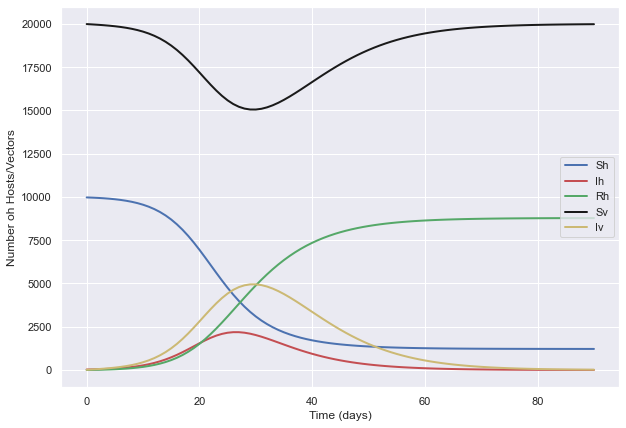

In [33]:
colors = ["b", "r", "g", "k", "y"]
labels = {"Sh":"Sh", "Ih":"Ih", "Rh":"Rh",
          "Sv":"Sv", "Iv":"Iv"}
plot_vbd_model(df, times, labels, colors);

#### Sensitivity of infection prevalence to the biting rate  
Theoretical studies of the behaviour of mathematical models under different parameter assumptions have had an important contribution to our understanding of VBD transmission dynamics and control. Here, we will do a simple **univariate sensitivity analysis** to explore how varying values of the biting rate affect infection prevalence in humans in our modelled dengue outbreak, keeping all other parameters constant.

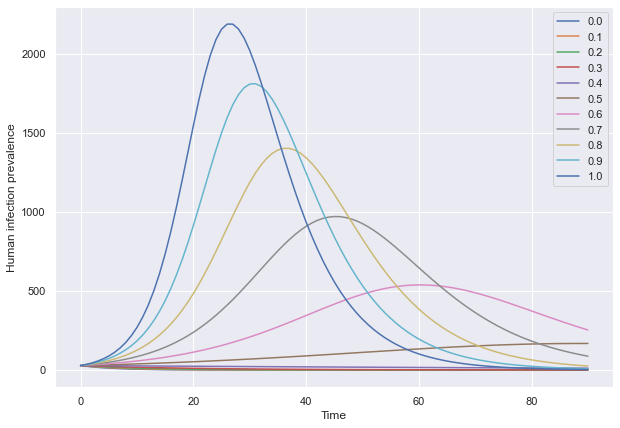

In [34]:
plt.figure(figsize=(10,7))
for a in np.linspace(0, 1, num=11):
    parameters = (a, b_v, b_h, u_v, r)
    df = pd.DataFrame(odeint(vbd_model, state, times, (parameters,)),
                  columns=["Sh", "Ih", "Rh", "Sv", "Iv"])
    plt.plot(times, df["Ih"], label=round(a,1))
    plt.ylabel("Human infection prevalence")
    plt.xlabel("Time")
    plt.legend()

**Q: How do assumptions of the mosquito biting activity affect the human infection prevalence?**

For an average number of 0-0.3 bites per mosquito per day, no dengue epidemic occurs. An outbreak only occurs for values of 0.4 and above, with increasing values of $a$ producing higher peak epidemic sizes and shorter durations.

**Q: What might affect the average number of bites a mosquito takes per unit time? Is it realistic to assume that the biting rate stays constant over time in the simulation?**

The biting rate, just like other vector-related parameters, can be influenced by a wide range of environmental factors such the temperature and rainfall. Over a short time period, assuming a constant biting rate may be fine, but accounting for seasonality is important over longer timescales (as is turnover in the human host population). The biting rate can also be affected by the host's behaviour, for example if humans take measures to avoid mosquito bites (e.g. wearing long-sleeve clothing).

**Q: How could you extend this model for a more realistic representation of dengue transmission dynamics?**

This would depend on the research question, but in general a more realistic model structure could be achieved by representing mosquito population dynamics and the natural history of dengue infection. For example, dengue models usually account for the intrinsic incubation period (latent period in humans) and extrinsic incubation period (latent period in the vector), i.e. the time between exposure to infection and the bite becoming infectious. Only adult mosquitoes are involved in transmission, but different developmental stages from larvae to adult could be represented, particularly if we are interested in studying changes in the mosquito population e.g. in relation to environmental factors. Severe cases of dengue infection occur as a result of secondary infection with a different serotype, so the co-circulation of different serotypes would be important to account for when studying disease burden of dengue in humans. 

Nishiura, Hiroshi (2006). Mathematical and Statistical Analyses of the Spread of Dengue. WHO Regional Office for South-East Asia. https://apps.who.int/iris/